<a href="https://colab.research.google.com/github/zenAurelius/HRAI3/blob/main/notebooks/test_base3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/HRAI/data

Mounted at /content/drive
/content/drive/MyDrive/HRAI/data


In [19]:
dfraw = pd.read_csv('pmu2017_os.zip')
list(dfraw.columns)

['aid_cr',
 'rfs_date',
 'rfs_heure',
 'ris_nom',
 'rfi_prix',
 'rfi_distance',
 'rfs_corde',
 'rfs_condSexe',
 'rfi_nbPartants',
 'rfs_hippodrome',
 'rfs_nebulosite',
 'rff_temperature',
 'rfi_ventForce',
 'rfi_ventDirection',
 'rfs_penetrometre',
 'rfi_typePiste',
 'rff_vmoy',
 'rfb_autostart',
 'rfb_amateurs',
 'pis_cheval_1',
 'pis_proprietaire_1',
 'pis_entraineur_1',
 'pis_driver_1',
 'pis_eleveur_1',
 'pfi_chAge_1',
 'pfs_chSexe_1',
 'pfs_chRace_1',
 'pib_partant_1',
 'pfb_oeilleres_1',
 'pfb_dvChange_1',
 'pfb_chInedit_1',
 'pfi_chNbCourses_1',
 'pfi_chNbVictoires_1',
 'pfi_chNbPlaces_1',
 'pfi_chNbSecond_1',
 'pfi_chNbTroisieme_1',
 'pff_chGainTotal_1',
 'pff_chGainVictoire_1',
 'pff_chGainPlace_1',
 'pff_chGainAnnee_1',
 'pff_chGainAnneePrec_1',
 'pfb_chEstJumentPleine_1',
 'pff_handicap_1',
 'pff_rapportDirect_1',
 'pff_tendanceDirect_1',
 'pff_permutationDirect_1',
 'pfb_favorisDirect_1',
 'pfb_priseDirect_1',
 'pff_rapportReference_1',
 'pff_tendanceReference_1',
 'pff_per

In [67]:
def complete(df, cols):
  cols_complete = []
  for b in (cols):
    if(b.endswith('_')):
      cols_complete.append(b + '1')
      cols_complete.append(b + '2')
    else:
      cols_complete.append(b)
  return cols_complete

def calc_ratio(df, ratio, num_features):
    for col in ratio:
      col1 = col + '1'
      col2 = col + '2'
      if col2 in df.columns:
        df[f'{col}_ratio'] = (df[col1] / (df[col1] + df[col2])).replace([np.inf, -np.inf, np.nan], 0.5).fillna(0.5)
        df[f'win_{col}'] = (df[f'{col}_ratio'] > 0.5).astype(int)
        num_features.append(f'{col}_ratio')
        #num_features.append(col1)
    return df


# INIT FEATURES/TARGET/CONST
NONFEATURES = ['aid_cr', 'pis_cheval_', 'tgi_ordreArrivee_', 'pff_rapportDirect_1', 'tgb_estGagnant_1', 'tgb_estPlace_1']
NONFEATURES = complete(dfraw, NONFEATURES)
RATIO_F = ['pfi_chAge_', 'pfi_chNbCourses_','pfi_chNbVictoires_','pfi_chNbPlaces_','pfi_chNbSecond_','pfi_chNbTroisieme_','pff_chGainTotal_','pff_chGainVictoire_','pff_chGainPlace_','pff_chGainAnnee_','pff_chGainAnneePrec_','pff_handicap_','pff_rapportDirect_','pff_rapportReference_','pfi_placeCorde_','pff_txReclamation_','pff_normcote_','pff_ord_']
NUM_FEATURES = []
CAT_FEATURES = ['pfs_dSexe']
CAT_FEATURES = []

dfraw = calc_ratio(dfraw, RATIO_F, NUM_FEATURES)
FEATURES = NUM_FEATURES + CAT_FEATURES


BATCH_SIZE = 256
MT_REG = 'regression'
MT_CLA = 'classification'
MODEL_TYPE = MT_REG
if MODEL_TYPE == 'classification':
  TARGET = ['tgf_win_1']
  NONFEATURES.append('tgf_pwin_1')
else:
  TARGET = ['tgf_pwin_1']
  NONFEATURES.append('tgf_win_1')
ALL_COLS = FEATURES + TARGET

df = dfraw[ALL_COLS + NONFEATURES].copy()
df

,pfi_chAge__ratio,pfi_chNbCourses__ratio,pfi_chNbVictoires__ratio,pfi_chNbPlaces__ratio,pfi_chNbSecond__ratio,pfi_chNbTroisieme__ratio,pff_chGainTotal__ratio,pff_chGainVictoire__ratio,pff_chGainPlace__ratio,pff_chGainAnnee__ratio,...,tgf_pwin_1,aid_cr,pis_cheval_1,pis_cheval_2,tgi_ordreArrivee_1,tgi_ordreArrivee_2,pff_rapportDirect_1,tgb_estGagnant_1,tgb_estPlace_1,tgf_win_1
0,0.5,0.720000,0.400000,0.750000,0.333333,1.000000,0.493863,0.438095,0.576778,0.460771,...,0.550000,170101R01C02,DEFI DE MEMARTIN,DEEPSTACK,9.0,11.0,243.0,False,False,1.0
1,0.5,0.580645,0.666667,0.428571,0.333333,0.500000,0.473378,0.560976,0.402415,0.455126,...,0.470588,170101R01C02,DEFI DE MEMARTIN,DAMOUR JIEL,9.0,8.0,243.0,False,False,0.0
2,0.5,0.545455,0.500000,0.562500,0.250000,0.333333,0.471377,0.589744,0.384277,0.438486,...,0.250000,170101R01C02,DEFI DE MEMARTIN,DOUGLAS,9.0,3.0,243.0,False,False,0.0
3,0.5,0.620690,0.666667,0.529412,0.500000,0.250000,0.469845,0.582278,0.385732,0.469828,...,0.357143,170101R01C02,DEFI DE MEMARTIN,DIABLE DE VAUVERT,9.0,5.0,243.0,False,False,0.0
4,0.5,0.545455,0.500000,0.692308,0.250000,1.000000,0.468941,0.534884,0.411633,0.436081,...,0.400000,170101R01C02,DEFI DE MEMARTIN,DADDY CASH,9.0,6.0,243.0,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410621,0.5,0.462963,0.800000,0.444444,0.181818,0.857143,0.510044,0.750000,0.403084,0.433647,...,0.521739,171231R04C07,CASH DE FAEL,CATARINA DE MARZY,11.0,12.0,6.9,False,False,1.0
1410622,0.5,0.423729,0.444444,0.500000,1.000000,0.666667,0.504117,0.428571,0.590437,0.764920,...,0.153846,171231R04C07,CASH DE FAEL,CALL ON ME RANAIS,11.0,2.0,6.9,False,False,0.0
1410623,0.5,0.454545,0.500000,0.461538,0.285714,0.750000,0.503768,0.474820,0.530597,0.483952,...,0.352941,171231R04C07,CASH DE FAEL,COACH D'OURVILLE,11.0,6.0,6.9,False,False,0.0
1410624,0.5,0.312500,1.000000,0.250000,0.333333,0.500000,0.503652,1.000000,0.356780,0.493582,...,0.388889,171231R04C07,CASH DE FAEL,CHEF CADE,11.0,7.0,6.9,False,False,0.0


In [ ]:
list(df.columns)

In [68]:
df = df[~df.pff_rapportDirect_1.isna()].copy()
df

,pfi_chAge__ratio,pfi_chNbCourses__ratio,pfi_chNbVictoires__ratio,pfi_chNbPlaces__ratio,pfi_chNbSecond__ratio,pfi_chNbTroisieme__ratio,pff_chGainTotal__ratio,pff_chGainVictoire__ratio,pff_chGainPlace__ratio,pff_chGainAnnee__ratio,...,tgf_pwin_1,aid_cr,pis_cheval_1,pis_cheval_2,tgi_ordreArrivee_1,tgi_ordreArrivee_2,pff_rapportDirect_1,tgb_estGagnant_1,tgb_estPlace_1,tgf_win_1
0,0.5,0.720000,0.400000,0.750000,0.333333,1.000000,0.493863,0.438095,0.576778,0.460771,...,0.550000,170101R01C02,DEFI DE MEMARTIN,DEEPSTACK,9.0,11.0,243.0,False,False,1.0
1,0.5,0.580645,0.666667,0.428571,0.333333,0.500000,0.473378,0.560976,0.402415,0.455126,...,0.470588,170101R01C02,DEFI DE MEMARTIN,DAMOUR JIEL,9.0,8.0,243.0,False,False,0.0
2,0.5,0.545455,0.500000,0.562500,0.250000,0.333333,0.471377,0.589744,0.384277,0.438486,...,0.250000,170101R01C02,DEFI DE MEMARTIN,DOUGLAS,9.0,3.0,243.0,False,False,0.0
3,0.5,0.620690,0.666667,0.529412,0.500000,0.250000,0.469845,0.582278,0.385732,0.469828,...,0.357143,170101R01C02,DEFI DE MEMARTIN,DIABLE DE VAUVERT,9.0,5.0,243.0,False,False,0.0
4,0.5,0.545455,0.500000,0.692308,0.250000,1.000000,0.468941,0.534884,0.411633,0.436081,...,0.400000,170101R01C02,DEFI DE MEMARTIN,DADDY CASH,9.0,6.0,243.0,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410621,0.5,0.462963,0.800000,0.444444,0.181818,0.857143,0.510044,0.750000,0.403084,0.433647,...,0.521739,171231R04C07,CASH DE FAEL,CATARINA DE MARZY,11.0,12.0,6.9,False,False,1.0
1410622,0.5,0.423729,0.444444,0.500000,1.000000,0.666667,0.504117,0.428571,0.590437,0.764920,...,0.153846,171231R04C07,CASH DE FAEL,CALL ON ME RANAIS,11.0,2.0,6.9,False,False,0.0
1410623,0.5,0.454545,0.500000,0.461538,0.285714,0.750000,0.503768,0.474820,0.530597,0.483952,...,0.352941,171231R04C07,CASH DE FAEL,COACH D'OURVILLE,11.0,6.0,6.9,False,False,0.0
1410624,0.5,0.312500,1.000000,0.250000,0.333333,0.500000,0.503652,1.000000,0.356780,0.493582,...,0.388889,171231R04C07,CASH DE FAEL,CHEF CADE,11.0,7.0,6.9,False,False,0.0


In [69]:
# SPLIT TRAIN, TEST, VAL

limit_train = df['aid_cr'].iloc[int(0.8 * len(df))]
limit_val = df['aid_cr'].iloc[int(0.9 * len(df))]
print(limit_train, limit_val)
train = df[df.aid_cr < limit_train].copy()
val = df[(df.aid_cr >= limit_train) & (df.aid_cr < limit_val)].copy()
test = df[df.aid_cr >= limit_val].copy()
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

171022R05C12 171125R04C04
1118762 training examples
139573 validation examples
140145 test examples


In [70]:
df['win_cote'] = (df.pff_normcote__ratio > 0.5).astype(int)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train[NUM_FEATURES] = scaler.fit_transform(train[NUM_FEATURES])
val[NUM_FEATURES] = scaler.transform(val[NUM_FEATURES])
test[NUM_FEATURES] = scaler.transform(test[NUM_FEATURES])

In [71]:
# CONVERSIONS INPUT

# DF TO DATASET
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe[ALL_COLS].copy()
  labels = df.pop(TARGET[0])
  df = {key: np.array(value)[:,tf.newaxis] for key, value in df.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

# GET INPUT LAYER
def get_input_layer(name, dataset):
  print(name)
  # normalizer = layers.Normalization(axis=None)
  # Récupère un dataset avec seulement les colonnes passées dans 'name'
  #feature_ds = dataset.map(lambda x, y: x[name])
  #print(feature_ds)
  #layers.Input(
  return layers.Input( name=name, shape=(), dtype="float32" )
  #normalizer.adapt(feature_ds)
  #return normalizer

# GET NORMALIZATION LAYER
def get_normalization_layer(name, dataset):
  print(name)
  normalizer = layers.Normalization(axis=None)
  # Récupère un dataset avec seulement les colonnes passées dans 'name'
  feature_ds = dataset.map(lambda x, y: x[name])
  print(feature_ds)
  normalizer.adapt(feature_ds)
  return normalizer

# GET CATEGORY ENCODING LAYER
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Lookup Layer, soit StringLookup, soit IntergerLookup
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Récupère un dataset avec seulement les colonnes passées dans 'name'
  feature_ds = dataset.map(lambda x, y: x[name])

  # Calcul le Lookup
  index.adapt(feature_ds)

  # Category Encoding à partir du nombre d'index trouvé
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [72]:
# TO DATASET

train_ds = df_to_dataset(train, shuffle=False, batch_size=BATCH_SIZE)
val_ds = df_to_dataset(val, shuffle=False, batch_size=BATCH_SIZE)
test_ds = df_to_dataset(test, shuffle=False, batch_size=BATCH_SIZE)

In [73]:
all_inputs = {}
encoded_features = []
import keras

#for header in NUM_FEATURES:
for header in NUM_FEATURES:
  numeric_col = tf.keras.Input(shape=(), name=header, dtype='float32')
  #normalization_layer = get_normalization_layer(header, train_ds)
  #encoded_numeric_col = normalization_layer(numeric_col)
  encoded_numeric_col = keras.ops.expand_dims(numeric_col,-1)
  all_inputs[header] = numeric_col
  encoded_features.append(encoded_numeric_col)

for header in CAT_FEATURES:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')


  #encoding_layer = get_category_encoding_layer(name=header,
  #                                             dataset=train_ds,
  #                                             dtype='string',
  #                                             max_tokens=9)
  #encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs[header] = categorical_col
  encoded_features.append(encoded_categorical_col)

In [74]:
# MODEL REGRESSION
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(64, activation="relu")(all_features)
x = layers.Dense(32, activation='relu')(x)
output = tf.keras.layers.Dense(1)(x)
print(encoded_features)

model = tf.keras.Model(all_inputs, output)
if(MODEL_TYPE == MT_REG):
  model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.001))
else:
  model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"],
              run_eagerly=True)

[<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_120>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_121>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_122>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_123>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_124>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_125>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_126>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_127>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_128>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_129>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_130>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_131>, <Ke

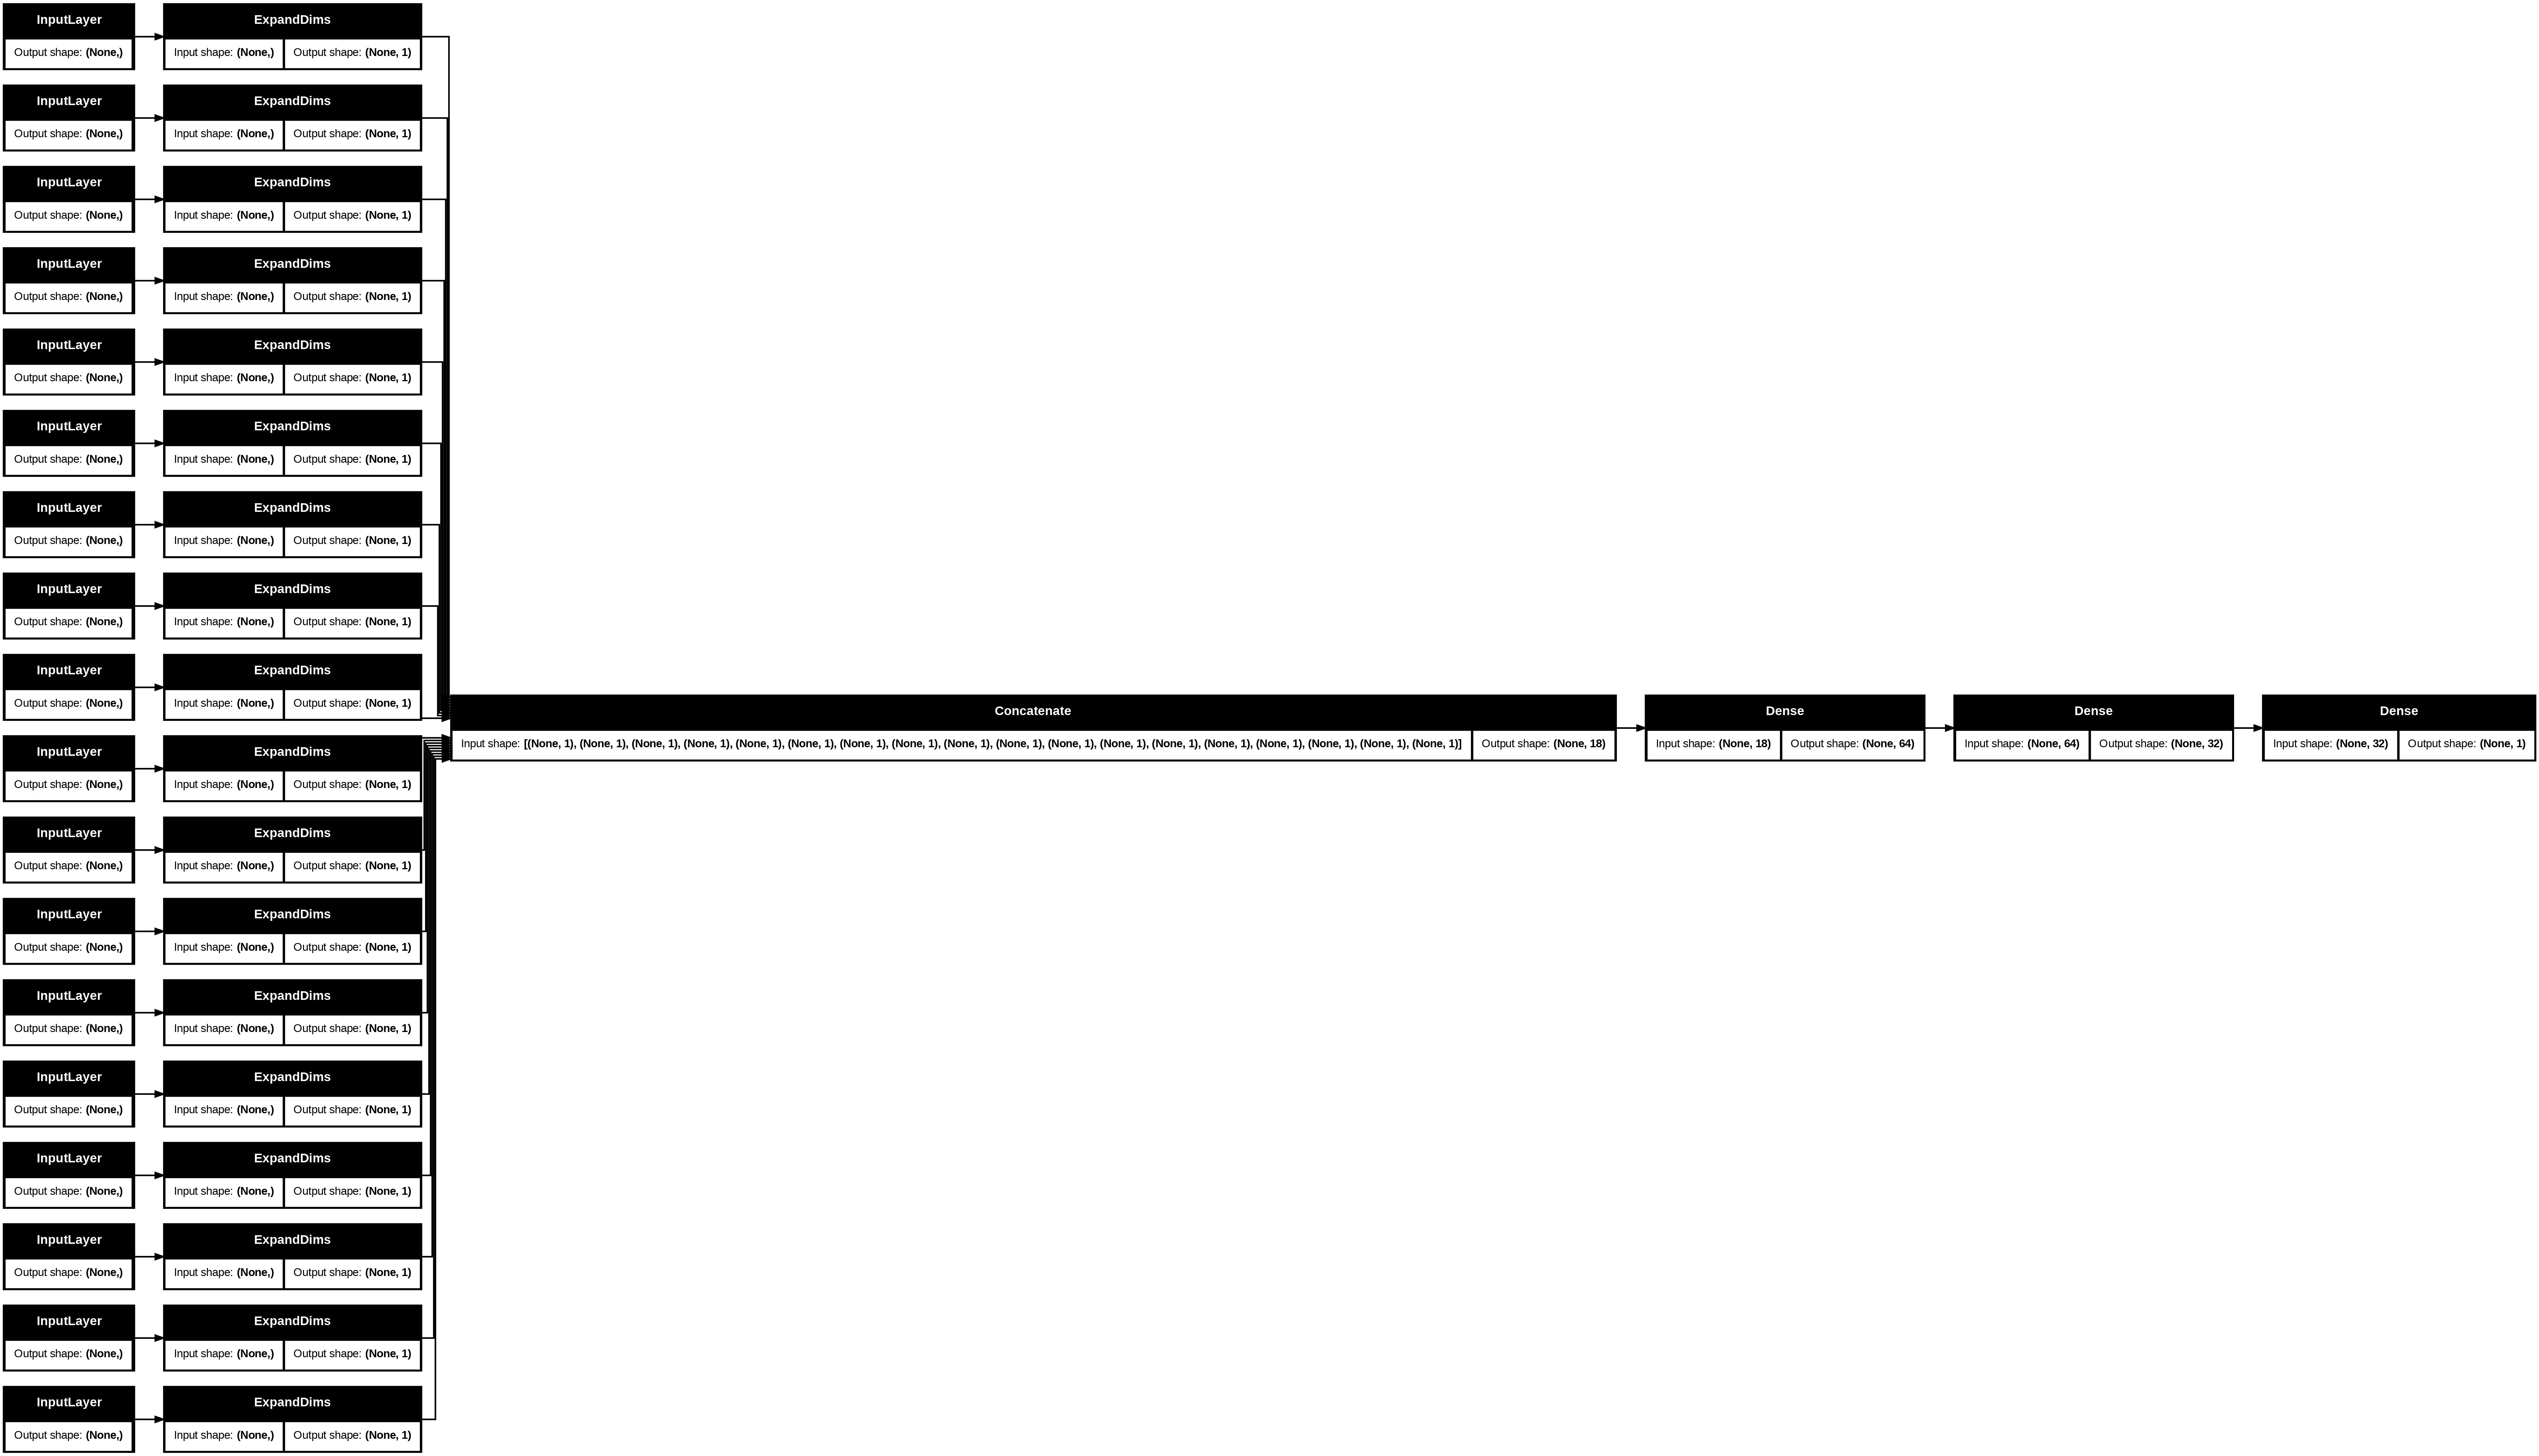

In [35]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [75]:
model.fit(train_ds, epochs=4, validation_data=val_ds)

Epoch 1/4
4371/4371 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - loss: 0.0506 - val_loss: 0.0384
Epoch 2/4
4371/4371 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.0389 - val_loss: 0.0378
Epoch 3/4
4371/4371 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.0382 - val_loss: 0.0376
Epoch 4/4
4371/4371 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 0.0382 - val_loss: 0.0375


In [78]:
def predict(model, ds, df, pcol):
  predictions = model.predict(ds)
  df[pcol] = predictions
  threshold = 0.5
  df[f'{pcol}_w'] = (predictions > threshold).astype(int)

  # Le reste pourrait être ailleurs
def prepare_comparaison(df):
  df['win1'] = (df.tgf_pwin_1 > 0.5).astype(int)

  #df['win_ord'] = (df.pff_dOrd > 0.5).astype(int)
  #df['win_gain'] = (df.pff_dGain > 0.5).astype(int)

def eval(df, pcol):
  print('positifs')
  print(len(df[(df[f'{pcol}_w'] == 1) & (df.win1 == 1)]) / len(df[(df.win1 == 1)]))
  #print(len(df[(df.win_cote == 0) & (df.win1 == 1)]) / len(df[(df.win1 == 1)]))
  #print(len(df[(df.win_ord == 1) & (df.win1 == 1)]) / len(df[(df.win1 == 1)]))
  print('negatifs')
  print(len(df[(df[f'{pcol}_w'] == 0) & (df.win1 == 0)]) / len(df[(df.win1 == 0)]))
  #print(len(df[(df.win_cote == 1) & (df.win1 == 0)]) / len(df[(df.win1 == 0)]))
  #print(len(df[(df.win_ord == 0) & (df.win1 == 0)]) / len(df[(df.win1 == 0)]))

In [42]:
train[train.win1 == 1]

,pfi_chAge__ratio,pfi_chNbCourses__ratio,pfi_chNbVictoires__ratio,pfi_chNbPlaces__ratio,pfi_chNbSecond__ratio,pfi_chNbTroisieme__ratio,pff_chGainTotal__ratio,pff_chGainVictoire__ratio,pff_chGainPlace__ratio,pff_chGainAnnee__ratio,...,pis_cheval_1,pis_cheval_2,tgi_ordreArrivee_1,tgi_ordreArrivee_2,pff_rapportDirect_1,tgf_win_1,pred,pred_w,win1,win_cote
0,0.000145,1.270428,-0.416740,1.190923,-0.648697,1.836301,-0.038798,-0.253794,0.351895,-0.127001,...,DEFI DE MEMARTIN,DEEPSTACK,9.0,11.0,243.0,1.0,0.361155,0,1,0
5,0.000145,0.465356,-0.000772,0.476000,-0.648697,-0.000480,-0.228673,-0.044250,-0.297587,0.407622,...,DEFI DE MEMARTIN,DZEUS D'AVIGNERE,9.0,11.0,243.0,1.0,0.424269,0,1,0
20,0.000145,-0.466440,-0.694052,0.339824,0.647313,-0.000480,0.159155,-0.249996,0.447477,0.142303,...,DAMOUR JIEL,DEFI DE MEMARTIN,8.0,9.0,30.0,1.0,0.616860,1,1,1
21,0.000145,0.866028,-1.040692,1.429231,-0.000692,1.836301,0.122153,-0.495552,0.776864,0.016816,...,DAMOUR JIEL,DEEPSTACK,8.0,11.0,30.0,1.0,0.441144,0,1,0
25,0.000145,-0.000542,-0.694052,0.793744,-0.000692,-0.000480,-0.068069,-0.292721,0.154607,0.538924,...,DAMOUR JIEL,DZEUS D'AVIGNERE,8.0,11.0,30.0,1.0,0.553186,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128201,0.000145,-0.000542,-0.000772,-0.000615,-0.000692,-0.000480,0.635015,-0.000768,-0.000798,-0.001386,...,GIAN LUCA PASEL,GINA EMC,2.0,7.0,3.1,1.0,0.654257,1,1,1
1128202,0.000145,-0.000542,-0.000772,-0.000615,-0.000692,-0.000480,0.498237,-0.000768,-0.000798,-0.001386,...,GIAN LUCA PASEL,JUDGE VRIJTHOUT,2.0,8.0,3.1,1.0,0.644852,1,1,1
1128203,0.000145,-0.000542,-0.000772,-0.000615,-0.000692,-0.000480,0.380128,-0.000768,-0.000798,-0.001386,...,GIAN LUCA PASEL,GERI BOKO,2.0,6.0,3.1,1.0,0.643351,1,1,1
1128204,-1.485009,-0.000542,-0.000772,-0.000615,-0.000692,-0.000480,0.270909,-0.000768,-0.000798,-0.001386,...,GIAN LUCA PASEL,FLAIR JE,2.0,9.0,3.1,1.0,0.647099,1,1,1


In [79]:
predict(model, train_ds, train, 'pred')
prepare_comparaison(train)
eval(train, 'pred')

4371/4371 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step
positifs
0.6719877116913924
negatifs
0.5871996452985514


In [80]:
predict(model, test_ds, test, 'pred')
prepare_comparaison(test)
eval(test, 'pred')

548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
positifs
0.6748731121564744
negatifs
0.5844069861363065


In [85]:
def pct_place(df):
    n = len(df)
    npl = len(df[df.tgb_estPlace_1])
    nga = len(df[df.tgb_estGagnant_1])
    print(f'placé {100 * npl / n:.2f}%  [{npl}/{n}] - gagnant {100 * nga / n:.2f}% [{nga}/{n}]')
    df['gain_gagnant'] = np.where(df['tgb_estGagnant_1'], df['pff_rapportDirect_1']-1, -1)
    print(f'gain gagnant = {df.gain_gagnant.sum()}')

In [86]:
result = test.groupby(['aid_cr', 'pis_cheval_1']).first().reset_index()
bycr = result.groupby('aid_cr')
result['pred_R'] = bycr['pred'].rank(ascending=False)
pct_place(result[result['pred_R'] == 1.0].copy())

placé 55.63%  [425/764] - gagnant 31.54% [241/764]
gain gagnant = -32.0


**TESTS**

In [ ]:
dfraw.pff_favorisReference_1.value_counts()

In [ ]:
# prompt: Pour toutes les colonnes qui commencent par 'pfi' ou 'pff' et finissent par '1' du dataframe dfraw, je voudrais calculer le rapport de la colonne qui fini par 1 avec la même colonnes mais finissant par '2'


# Assuming 'dfraw' is your DataFrame and it's already loaded as in your provided code

def calculate_ratio(df):
    for col in df.columns:
        if (col.startswith('pfi') or col.startswith('pff')) and col.endswith('1'):
            rootc = col[:-1]
            print(rootc)
            col2 = rootc + '2'  # Construct the corresponding column name ending with '2'
            if col2 in df.columns:
                df[f'{rootc}_ratio'] = df[col] / (df[col] + df[col2])
                df[f'win_{rootc}'] = (df[f'{rootc}_ratio'] > 0.5).astype(int)
                print(df[df[f'win_{rootc}'] == 1].tgf_win_1.value_counts())
            else:
                print(f"Warning: Column '{col2}' not found for '{col}'. Ratio calculation skipped.")
    return df

dfraw = calculate_ratio(dfraw)


In [ ]:
df['win_nbv'] = (df.pfi_dNbVictoires > 0.5).astype(int)
df['win_gain'] = (df.pff_dGain > 0.5).astype(int)

In [ ]:
df[df.win_gain == 1].tgf_win_1.value_counts()

In [ ]:
df[df.win_nbv == 0].tgf_win_1.value_counts()

In [ ]:
# prompt: je veux la première moitié des enregistrements de test

# Get the first half of the test dataset
half_test = int(len(test) / 2)
first_half_test = test.head(half_test)

# Now you can work with the first_half_test DataFrame
print(len(first_half_test), 'first half of test examples')
# Example: Print the first few rows
print(first_half_test.head())


In [ ]:
half_test = int(len(test) / 2)
train0 = test.head(half_test)
train1 = test.tail(half_test)
print(len(train0[(train0.win_ord == 1) & (train0.win1 == 1)]) / len(train0[(train0.win1 == 1)]))
print(len(train1[(train1.win_ord == 1) & (train1.win1 == 1)]) / len(train1[(train1.win1 == 1)]))

In [ ]:
# prompt: je veux selectionner tout les enregistrements ou OS_N_SG_pis_cheval_1 est supérieur à sa valeur médiane

median_value = dfraw['OS_N_SG_pis_cheval_1'].median()
filtered_df = dfraw[dfraw['OS_N_SG_pis_cheval_1'] < median_value].copy()

# prompt: sur ce qui reste que je veux connaitre la valeur moyenne de OS_N_MU_pis_cheval_1 pour chaque quartile de pff_chGainTotal_1

# Calculate quartiles for pff_chGainTotal_1
filtered_df['quartile'] = pd.qcut(filtered_df['pff_chGainTotal_1'] / filtered_df['pfi_chNbCourses_1'], 4, labels=False)

# Group by quartile and calculate the mean of OS_N_MU_pis_cheval_1
mean_by_quartile = filtered_df.groupby('quartile')['OS_N_MU_pis_cheval_1'].mean()

mean_by_quartile

In [ ]:
# prompt: pour tout les enregistrement où pff_mu_pis_cheval_1 est = 25, je veux que la valeur soit remplacé par 24 si pff_chGainTotal_1 / pfi_chNbCourses_1 < 110000, par 29 si >110000 et <174000, par 32 si >174000 et <285000 et par 36 si > 285000

# Create a copy to avoid SettingWithCopyWarning
filtered_df = filtered_df.copy()

# Apply the conditions and update pff_mu_pis_cheval_1
filtered_df.loc[
    (filtered_df['pff_mu_pis_cheval_1'] == 25) &
    (filtered_df['pff_chGainTotal_1'] / filtered_df['pfi_chNbCourses_1'] < 110000),
    'pff_mu_pis_cheval_1'
] = 24

filtered_df.loc[
    (filtered_df['pff_mu_pis_cheval_1'] == 25) &
    (filtered_df['pff_chGainTotal_1'] / filtered_df['pfi_chNbCourses_1'] >= 110000) &
    (filtered_df['pff_chGainTotal_1'] / filtered_df['pfi_chNbCourses_1'] < 174000),
    'pff_mu_pis_cheval_1'
] = 29

filtered_df.loc[
    (filtered_df['pff_mu_pis_cheval_1'] == 25) &
    (filtered_df['pff_chGainTotal_1'] / filtered_df['pfi_chNbCourses_1'] >= 174000) &
    (filtered_df['pff_chGainTotal_1'] / filtered_df['pfi_chNbCourses_1'] < 285000),
    'pff_mu_pis_cheval_1'
] = 32

filtered_df.loc[
    (filtered_df['pff_mu_pis_cheval_1'] == 25) &
    (filtered_df['pff_chGainTotal_1'] / filtered_df['pfi_chNbCourses_1'] >= 285000),
    'pff_mu_pis_cheval_1'
] = 36

In [ ]:
# prompt: je veux connnaitre les bornes des quartiles de pff_chGainTotal_1 / pfi_chNbCourses_1

# Calculate quartiles for pff_chGainTotal_1 / pfi_chNbCourses_1
filtered_df['quartile_ratio'] = pd.qcut(filtered_df['pff_chGainTotal_1'] / filtered_df['pfi_chNbCourses_1'], 4, labels=False)

# Get the boundaries of each quartile
quartiles = filtered_df['pff_chGainTotal_1'] / filtered_df['pfi_chNbCourses_1']
quartile_bounds = quartiles.quantile([0.25, 0.5, 0.75])

quartile_bounds

In [ ]:
df = df[df.tgf_win_1 != 0.5]
print(len(df[(df.pfs_dSexe == 'FF') & (df.tgf_win_1 == 1)]) / len(df[(df.pfs_dSexe == 'FF')]))
print(len(df[(df.pfs_dSexe == 'FM') & (df.tgf_win_1 == 1)]) / len(df[(df.pfs_dSexe == 'FM')]))
print(len(df[(df.pfs_dSexe == 'FH') & (df.tgf_win_1 == 1)]) / len(df[(df.pfs_dSexe == 'FH')]))
print(len(df[(df.pfs_dSexe == 'HF') & (df.tgf_win_1 == 1)]) / len(df[(df.pfs_dSexe == 'HF')]))
print(len(df[(df.pfs_dSexe == 'HM') & (df.tgf_win_1 == 1)]) / len(df[(df.pfs_dSexe == 'HM')]))
print(len(df[(df.pfs_dSexe == 'HH') & (df.tgf_win_1 == 1)]) / len(df[(df.pfs_dSexe == 'HH')]))
print(len(df[(df.pfs_dSexe == 'MM') & (df.tgf_win_1 == 1)]) / len(df[(df.pfs_dSexe == 'MM')]))
print(len(df[(df.pfs_dSexe == 'MF') & (df.tgf_win_1 == 1)]) / len(df[(df.pfs_dSexe == 'MF')]))
print(len(df[(df.pfs_dSexe == 'MH') & (df.tgf_win_1 == 1)]) / len(df[(df.pfs_dSexe == 'MH')]))

In [ ]:
[(train_features, label_batch)] = train_ds.take(1)
test_type_col = train_features['diff_sexe']
test_type_layer = get_category_encoding_layer(name='diff_sexe',
                                              dataset=train_ds,
                                              dtype='string',
                                              max_tokens=5)
test_type_layer(test_type_col)

In [ ]:
model.save('classifier_test2.keras')
reloaded_model = tf.keras.models.load_model('classifier_test.keras')

In [ ]:
predictions = model.predict(test_ds)
predictions

In [ ]:
# prompt: je veux mettre le résultat des prédictions dans une colonne 'pred' du dataframe d'origine 'test'

# Convert predictions to a binary classification (e.g., using a threshold)
threshold = 0.0
binary_predictions = (predictions > threshold).astype(int)

# Add the predictions as a new column 'pred' to the test dataframe
test['pred'] = binary_predictions

# Print the updated dataframe with predictions
test.pred.value_counts()

In [ ]:
test.tgf_win_1.value_counts()

In [ ]:
# prompt: dans dataframe 'test' je veux une colonne win_cote qui contient 1 si rapport 2 > rapport 1 et 0 sinon

test['win_cote'] = (test['diff_cote'] < 0.5).astype(int)
test['win_ord'] = (test['diff_ord'] > 0.5).astype(int)

In [ ]:
test

In [ ]:
print(len(test[(test.pred == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.tgf_win_1 == 1)]))
print(len(test[(test.win_cote == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.tgf_win_1 == 1)]))
print(len(test[(test.win_ord == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.tgf_win_1 == 1)]))
print(len(test[(test.win_cote == 1) & (test.win_ord == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.tgf_win_1 == 1)]))

In [ ]:
print(len(test[(test.pred == 0) & (test.tgf_win_1 == 0)]) / len(test[(test.tgf_win_1 == 0)]))
print(len(test[(test.win_cote == 0) & (test.tgf_win_1 == 0)]) / len(test[(test.tgf_win_1 == 0)]))
print(len(test[(test.win_ord == 0) & (test.tgf_win_1 == 0)]) / len(test[(test.tgf_win_1 == 0)]))

In [ ]:
print(len(test[(test.pred == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.pred == 1)]))
print(len(test[(test.pred2 == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.pred2 == 1)]))
print(len(test[(test.win_cote == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.win_cote == 1)]))
print(len(test[(test.win_ord == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.win_ord == 1)]))
print(len(test[(test.win_cote == 1) & (test.win_ord == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.win_cote == 1) & (test.win_ord == 1)]))
print(len(test[(test.win_cote == 0) & (test.pred == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.win_cote == 0) & (test.pred == 1)]))